# PyTorch AutoEncoder (MNIST)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# 하이퍼파라미터

In [4]:
batch_size = 128
epochs = 20
learning_rate = 1e-3
folder_path = 'result_ipynb'

# MNIST 데이터셋 로드

In [5]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# AutoEncoder 모델 정의

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 12),
            nn.GELU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프

In [7]:
model.train()
for epoch in range(1, epochs+1):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
# 학습 종료 후 가중치 저장
weight_path = os.path.join(folder_path, "weight")
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
torch.save(model.state_dict(), os.path.join(weight_path, 'autoencoder_weights.pth'))

Epoch [1/20], Loss: 0.0669
Epoch [2/20], Loss: 0.0505
Epoch [3/20], Loss: 0.0444
Epoch [4/20], Loss: 0.0417
Epoch [5/20], Loss: 0.0402
Epoch [6/20], Loss: 0.0391
Epoch [7/20], Loss: 0.0382
Epoch [8/20], Loss: 0.0374
Epoch [9/20], Loss: 0.0367
Epoch [10/20], Loss: 0.0362
Epoch [11/20], Loss: 0.0358
Epoch [12/20], Loss: 0.0353
Epoch [13/20], Loss: 0.0349
Epoch [14/20], Loss: 0.0345
Epoch [15/20], Loss: 0.0343
Epoch [16/20], Loss: 0.0340
Epoch [17/20], Loss: 0.0337
Epoch [18/20], Loss: 0.0334
Epoch [19/20], Loss: 0.0332
Epoch [20/20], Loss: 0.0330


# 테스트 및 결과 시각화

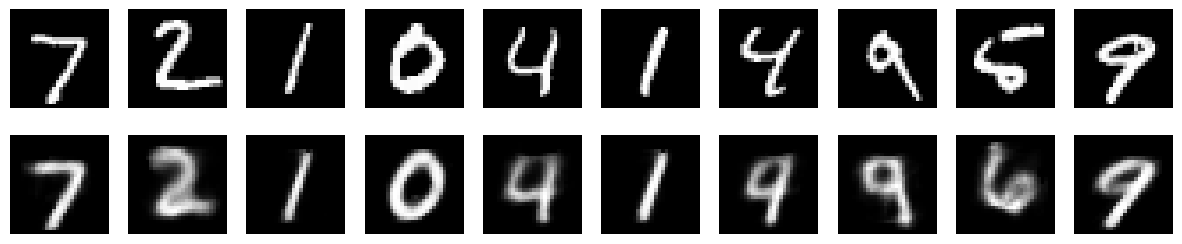

In [8]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        break  # 첫 배치만 시각화
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# result 폴더 생성
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('입력')
axes[1, 0].set_ylabel('복원')
plt.show()

In [9]:
plt.savefig(os.path.join(folder_path, 'autoencoder_results.png'))

<Figure size 640x480 with 0 Axes>